# Diabetes Prediction Task
This notebook predicts the onset of diabetes using patient data. It follows the task requirements:
1. Use Logistic Regression as a baseline.
2. Compare Logistic Regression with Decision Tree and SVM.
3. Apply feature engineering to create meaningful features.
4. Evaluate model performance using cross-validation.

# Import Libraries

In [63]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import seaborn as sns
from sklearn import model_selection,metrics
from sklearn.metrics import accuracy_score, confusion_matrix

## read data

In [64]:
data=pd.read_csv("diabetes.csv")
data.head(4)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0


In [65]:
# data = data.iloc[2:].reset_index(drop=True)
# data.head()

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [67]:
print(f"Number of Rows {data.shape[0]} and number of colummns {data.shape[1]}")

Number of Rows 768 and number of colummns 9


## Data Preprocessing
1. Handle zero values in columns like `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI`.
2. Perform feature scaling if required.


In [68]:
(data.isna().sum()/data.shape[0])*100

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

In [69]:
((data==0).sum()/data.shape[0])*100

Pregnancies                 14.453125
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                     65.104167
dtype: float64

In [70]:
(data.duplicated().sum()/data.shape[0])*100

0.0

## Identify columns to replace zeros


In [71]:
columns_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
# Ensure columns are float
data[columns_to_fix] = data[columns_to_fix].astype(float)

In [72]:
# Replace zeros using median (Debind on outcome)
for col in columns_to_fix:
    for outcome in [0, 1]:
        median = data[data['Outcome'] == outcome][col][data[col] != 0].median()
        data.loc[(data['Outcome'] == outcome) & (data[col] == 0), col] = median

## remove outliers

In [73]:
# Function to calculate outliers
def calculate_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_below = df[df[column] < lower_bound].shape[0]
    outliers_above = df[df[column] > upper_bound].shape[0]
    total_outliers = outliers_below + outliers_above

    # Print the results
    print(f"Column: {column}")
    print(f" - Q1: {Q1}")
    print(f" - Q3: {Q3}")
    print(f" - IQR: {IQR}")
    print(f" - Lower Bound: {lower_bound}")
    print(f" - Upper Bound: {upper_bound}")
    print(f" - Outliers Below: {outliers_below}")
    print(f" - Outliers Above: {outliers_above}")
    print(f" - Total Outliers: {total_outliers}")

    return total_outliers

In [74]:
# Check for outliers in 'Pregnancies' column
pregnancies = calculate_outliers(data, 'Pregnancies')

Column: Pregnancies
 - Q1: 1.0
 - Q3: 6.0
 - IQR: 5.0
 - Lower Bound: -6.5
 - Upper Bound: 13.5
 - Outliers Below: 0
 - Outliers Above: 4
 - Total Outliers: 4


In [75]:
# Check for outliers in 'Glucose' column
glucose = calculate_outliers(data, 'Glucose')

Column: Glucose
 - Q1: 99.75
 - Q3: 140.25
 - IQR: 40.5
 - Lower Bound: 39.0
 - Upper Bound: 201.0
 - Outliers Below: 0
 - Outliers Above: 0
 - Total Outliers: 0


In [76]:
# Check for outliers in 'BloodPressure' column
blood_pressure = calculate_outliers(data, 'BloodPressure')

Column: BloodPressure
 - Q1: 64.0
 - Q3: 80.0
 - IQR: 16.0
 - Lower Bound: 40.0
 - Upper Bound: 104.0
 - Outliers Below: 4
 - Outliers Above: 10
 - Total Outliers: 14


In [77]:
# Check for outliers in 'SkinThickness' column
skin_thickness = calculate_outliers(data, 'SkinThickness')

Column: SkinThickness
 - Q1: 25.0
 - Q3: 32.0
 - IQR: 7.0
 - Lower Bound: 14.5
 - Upper Bound: 42.5
 - Outliers Below: 39
 - Outliers Above: 48
 - Total Outliers: 87


In [78]:
# Check for outliers in 'Insulin' column
insulin = calculate_outliers(data, 'Insulin')

Column: Insulin
 - Q1: 102.5
 - Q3: 169.5
 - IQR: 67.0
 - Lower Bound: 2.0
 - Upper Bound: 270.0
 - Outliers Below: 0
 - Outliers Above: 51
 - Total Outliers: 51


In [79]:
# Check for outliers in 'BMI' column
bmi = calculate_outliers(data, 'BMI')

Column: BMI
 - Q1: 27.5
 - Q3: 36.6
 - IQR: 9.100000000000001
 - Lower Bound: 13.849999999999998
 - Upper Bound: 50.25
 - Outliers Below: 0
 - Outliers Above: 8
 - Total Outliers: 8


In [80]:
# Check for outliers in 'DiabetesPedigreeFunction' column
diabetes_pedigree_function = calculate_outliers(data, 'DiabetesPedigreeFunction')

Column: DiabetesPedigreeFunction
 - Q1: 0.24375
 - Q3: 0.62625
 - IQR: 0.38249999999999995
 - Lower Bound: -0.32999999999999996
 - Upper Bound: 1.2
 - Outliers Below: 0
 - Outliers Above: 29
 - Total Outliers: 29


In [81]:
# Check for outliers in 'Age' column
age = calculate_outliers(data, 'Age')

Column: Age
 - Q1: 24.0
 - Q3: 41.0
 - IQR: 17.0
 - Lower Bound: -1.5
 - Upper Bound: 66.5
 - Outliers Below: 0
 - Outliers Above: 9
 - Total Outliers: 9


## Function to remove outliers for a given column

In [82]:
# Function to remove outliers for a given column
def remove_outlier(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove rows that contain outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [83]:
# remove outliers from 'SkinThickness'
data = remove_outlier(data, 'SkinThickness')


In [84]:
# remove outliers from 'BloodPressure'
# data = remove_outlier(data, 'BloodPressure')


In [85]:
# remove outliers from 'Insulin'
data = remove_outlier(data, 'Insulin')

In [86]:
# remove outliers from 'BMI'
data = remove_outlier(data, 'BMI')

In [87]:
# remove outliers from 'DiabetesPedigreeFunction'
# data = replace_outlier_with_median_by_target(data, 'DiabetesPedigreeFunction')

In [88]:
# remove outliers from 'Age'
# data = replace_outlier_with_median_by_target(data, 'Age')

In [89]:
# # Display cleaned data
# print("Cleaned Data Shape:", data.shape)

## visualization

In [90]:
# data.hist(figsize=(15,15))

In [91]:
# sns.regplot(x="Age", y="Glucose", data=data)

In [92]:
# sns.lmplot(x="Age", y="Glucose", hue="Outcome", data=data)

In [93]:
# df_out = pd.DataFrame(data.Outcome)
# data=data.drop('Outcome',axis=1)

In [94]:
# for i in data.columns:
#   for j in range(len(data)):
#     data.iloc[j,data.columns.get_loc(i)] = (data.iloc[j,data.columns.get_loc(i)]-data[i].mean())/np.std(data[i])

In [95]:
# for i in data.columns:
#   for j in range(len(data)):
#     data.iloc[j,data.columns.get_loc(i)] = data.iloc[j,data.columns.get_loc(i)]/data[i].max()

In [96]:
# data=pd.concat([data,df_out],axis=1)

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 632 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               632 non-null    int64  
 1   Glucose                   632 non-null    float64
 2   BloodPressure             632 non-null    float64
 3   SkinThickness             632 non-null    float64
 4   Insulin                   632 non-null    float64
 5   BMI                       632 non-null    float64
 6   DiabetesPedigreeFunction  632 non-null    float64
 7   Age                       632 non-null    int64  
 8   Outcome                   632 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 49.4 KB


In [98]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter


X = data.drop('Outcome', axis=1)
y = data['Outcome']

print("توزيع الفئات قبل SMOTE:", Counter(y))

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print("توزيع الفئات بعد SMOTE:", Counter(y_smote))

balanced_data = pd.concat([pd.DataFrame(X_smote, columns=X.columns), pd.DataFrame(y_smote, columns=['Outcome'])], axis=1)
df=balanced_data.copy()

# /////////////////////////////////////////////////////////////////////////////////


توزيع الفئات قبل SMOTE: Counter({0: 423, 1: 209})
توزيع الفئات بعد SMOTE: Counter({1: 423, 0: 423})


In [99]:

# تطبيق normalization
scaler = MinMaxScaler()
columns_to_scale = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin'
                    , 'BMI', 'Age',
                    ]
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [100]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']


## Train-Test Split

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
## normalize the data

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# x_train=scaler.transform(X_train)
# x_test=scaler.transform(X_test)

In [103]:
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
665,0.176471,0.575553,0.515306,0.629630,0.604331,0.496088,0.308276,0.033333
633,0.235294,0.490572,0.367347,0.793258,0.604331,0.477175,0.283362,0.350000
570,0.000000,0.359477,0.469388,0.444444,0.340551,0.228956,0.253000,0.016667
788,0.058824,0.498854,0.583993,0.780955,0.787504,0.809273,0.825750,0.133333
539,0.058824,0.405229,0.469388,0.481481,0.468504,0.538721,0.142000,0.016667
...,...,...,...,...,...,...,...,...
71,0.117647,0.431373,0.510204,0.518519,0.429134,0.478114,0.698000,0.100000
106,0.000000,0.450980,0.530612,0.629630,0.604331,0.508418,0.278000,0.033333
270,0.117647,0.379085,0.632653,0.777778,0.409449,0.919192,0.127000,0.033333
435,0.000000,0.477124,0.428571,0.592593,0.677165,0.424242,0.493000,0.016667


In [104]:
X_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
39,0.411765,0.751634,0.408163,0.444444,0.340551,0.309764,0.294000,0.316667
250,0.176471,0.692810,0.530612,0.444444,0.340551,0.094276,0.207000,0.266667
314,0.000000,0.398693,0.448980,0.259259,0.340551,0.060606,0.236000,0.016667
96,0.235294,0.209150,0.387755,0.444444,0.340551,0.531987,0.391000,0.066667
198,0.000000,0.392157,0.530612,0.444444,0.340551,0.006734,0.582000,0.100000
...,...,...,...,...,...,...,...,...
792,0.235294,0.351263,0.397984,0.555738,0.604331,0.418464,0.194667,0.150000
2,0.470588,0.908497,0.408163,0.629630,0.604331,0.171717,0.672000,0.183333
760,0.764706,0.857249,0.388296,0.555556,0.605427,0.518965,0.215075,0.283333
778,0.235294,0.934641,0.526254,0.431261,0.750007,0.837961,0.989436,0.500000


In [105]:
log_reg = LogisticRegression(max_iter=500)  
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [106]:
y_pred=log_reg.predict(X_test)
metrics.mean_squared_error(y_test,y_pred)

0.10588235294117647

In [107]:
accuracy = metrics.accuracy_score(y_test,y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 89.41%


In [108]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [109]:
y_pred=decision_tree.predict(X_test)
metrics.mean_squared_error(y_test,y_pred)

0.13529411764705881

In [110]:
accuracy = metrics.accuracy_score(y_test,y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 86.47%


In [111]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)

SVC(probability=True)

In [112]:
y_pred=svm.predict(X_test)
metrics.mean_squared_error(y_test,y_pred)

0.08235294117647059

In [113]:
accuracy = metrics.accuracy_score(y_test,y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 91.76%


In [114]:
# import joblib

# joblib.dump(log_reg, 'logistic_regression_model.pkl')
# joblib.dump(svm, 'svm_model.pkl')
# joblib.dump(decision_tree, 'decision_tree_model.pkl')
# joblib.dump(scaler, 'scaler.pkl')

In [115]:
log_pred = log_reg.predict(X_test)
dt_pred = decision_tree.predict(X_test)
svm_pred = svm.predict(X_test)

print("Logistic Regression Report:\n", classification_report(y_test, log_pred))
print("Decision Tree Report:\n", classification_report(y_test, dt_pred))
print("SVM Report:\n", classification_report(y_test, svm_pred))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89        83
           1       0.91      0.89      0.90        87

    accuracy                           0.89       170
   macro avg       0.89      0.89      0.89       170
weighted avg       0.89      0.89      0.89       170

Decision Tree Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.86        83
           1       0.88      0.85      0.87        87

    accuracy                           0.86       170
   macro avg       0.86      0.87      0.86       170
weighted avg       0.87      0.86      0.86       170



SVM Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91        83
           1       0.91      0.93      0.92        87

    accuracy                           0.92       170
   macro avg       0.92      0.92      0.92       170
weighted avg       0.92      0.92      0.92       170



In [116]:
print("Accuracy Scores:")
print("Logistic Regression:", accuracy_score(y_test, log_pred))
print("Decision Tree:", accuracy_score(y_test, dt_pred))
print("SVM:", accuracy_score(y_test, svm_pred))

Accuracy Scores:
Logistic Regression: 0.8941176470588236
Decision Tree: 0.8647058823529412
SVM: 0.9176470588235294


In [117]:
cv_log_reg = cross_val_score(log_reg, X, y, cv=5, scoring='accuracy')
cv_decision_tree = cross_val_score(decision_tree, X, y, cv=5, scoring='accuracy')
cv_svm = cross_val_score(svm, X, y, cv=5, scoring='accuracy')

In [118]:
print("Cross-Validation Scores:")
print(f"Logistic Regression: {cv_log_reg.mean()}")
print(f"Decision Tree: {cv_decision_tree.mean()}")
print(f"SVM: {cv_svm.mean()}")

Cross-Validation Scores:
Logistic Regression: 0.8581691611555865
Decision Tree: 0.8924051514096764
SVM: 0.8865297598329273


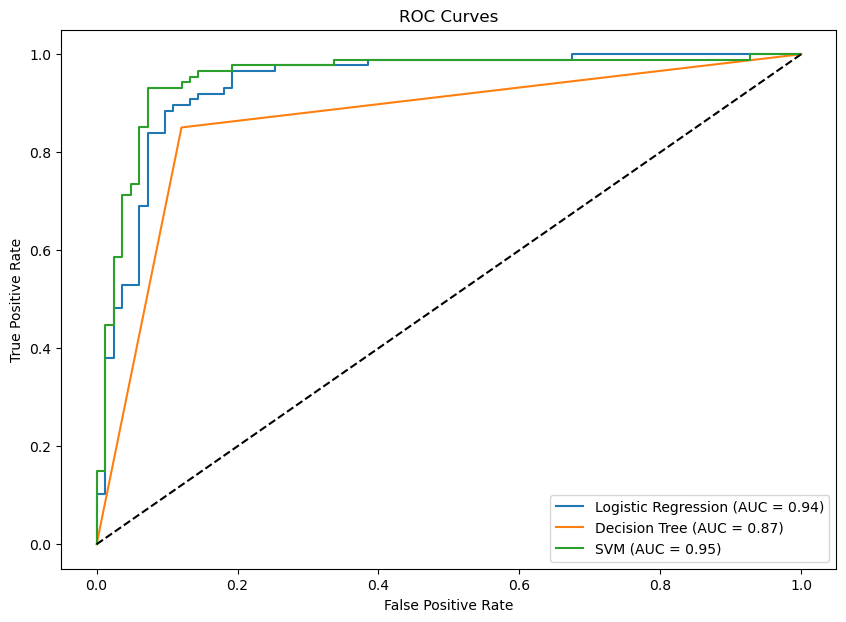

In [119]:
plt.figure(figsize=(10, 7))
fpr_log, tpr_log, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
log_roc_auc = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {log_roc_auc:.2f})")

# Decision Tree ROC
fpr_dt, tpr_dt, _ = roc_curve(y_test, decision_tree.predict_proba(X_test)[:, 1])
dt_roc_auc = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {dt_roc_auc:.2f})")

# SVM ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm.predict_proba(X_test)[:, 1])
svm_roc_auc = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {svm_roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


## Compare Model Performances

In [120]:
# Compare models
results = {
    "Logistic Regression": cv_log_reg.mean(),
    "Decision Tree": cv_decision_tree.mean(),
    "SVM": cv_svm.mean()
}

best_model_name = max(results, key=results.get)
print(f"Best Model: {best_model_name} with Accuracy: {results[best_model_name]:.4f}")

Best Model: Decision Tree with Accuracy: 0.8924


## Best Model Evaluation

In [121]:
# Train the best model on the full training set
if best_model_name == "Logistic Regression":
    best_model = log_reg
elif best_model_name == "Decision Tree":
    best_model = decision_tree
else:
    best_model = svm

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Evaluate the best model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        83
           1       0.89      0.85      0.87        87

    accuracy                           0.87       170
   macro avg       0.87      0.87      0.87       170
weighted avg       0.87      0.87      0.87       170

Confusion Matrix:
[[74  9]
 [13 74]]


## predict unseen data

In [122]:
# # Define the features
# columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# # Get inputs from the user
# new_data = {}
# print("Enter the values for the following features:")
# for col in columns:
#     while True:
#         try:
#             value = input(f"Enter value for {col}: ").strip()  # Remove any extra spaces
#             value = float(value)  # Convert the input to a float
#             new_data[col] = value
#             break  
#         except ValueError:
#             print(f"Error: You must enter a valid numeric value for {col}. Please try again.")

# # Convert the input data into a DataFrame
# unseen_data = pd.DataFrame([new_data])
# print("Entered data:")
# print(unseen_data)

# # Predict using the model
# unseen_prediction = decision_tree.predict(unseen_data) 
# print("Prediction for the entered data:", unseen_prediction[0])

## GUI

In [123]:
# from sklearn.tree import DecisionTreeClassifier
# import joblib
# # Example of training a model
# model = DecisionTreeClassifier()
# model.fit(X_train, y_train)  # Assume X_train and y_train are your training data

# # Save the trained model to a file
# joblib.dump(model, 'decision_tree_model.pkl')


In [124]:
# import tkinter as tk
# from tkinter import messagebox
# import joblib  # Import joblib to load the saved model

# # Define the features (columns) that are used in the model
# columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# # Load the trained model (replace 'decision_tree_model.pkl' with the actual model file path)
# decision_tree = joblib.load('decision_tree_model.pkl')

# # Function to handle the prediction
# def predict():
#     new_data = {}
#     try:
#         # Collect input data
#         for col in columns:
#             value = float(entry_dict[col].get())  # Get the value from the entry widget
#             new_data[col] = value
        
#         # Convert the input data into a DataFrame
#         unseen_data = pd.DataFrame([new_data])
        
#         # Predict using the model
#         unseen_prediction = decision_tree.predict(unseen_data)
        
#         # Display the prediction result
#         prediction_result = "Diabetic" if unseen_prediction[0] == 1 else "Not Diabetic"
#         messagebox.showinfo("Prediction Result", f"Prediction for the entered data: {prediction_result}")
#     except ValueError:
#         messagebox.showerror("Invalid Input", "Please enter valid numeric values for all fields.")

# # Create the main window
# root = tk.Tk()
# root.title("Diabetes Prediction")

# # Create a dictionary to store the Entry widgets for each feature
# entry_dict = {}

# # Create the labels and entry widgets dynamically based on the columns
# for idx, col in enumerate(columns):
#     label = tk.Label(root, text=f"{col}:")
#     label.grid(row=idx, column=0, padx=10, pady=5)
    
#     entry = tk.Entry(root)
#     entry.grid(row=idx, column=1, padx=10, pady=5)
#     entry_dict[col] = entry

# # Create the Predict button
# predict_button = tk.Button(root, text="Predict", command=predict)
# predict_button.grid(row=len(columns), column=0, columnspan=2, pady=20)

# # Start the GUI event loop
# root.mainloop()
